In [6]:
import os
import shutil
import vcf
import re
import gzip
import pandas as pd
import pysam

from IPython.display import Image
from Bio import SeqIO


## import rpy2.ipython


## %load_ext rpy2.ipython

os.chdir("/master/nplatt/sch_man_nwinvasion")

# Calculate Descriptive Stats

Calculate basic descriptive stats including read count, sample coverage, probe depth etc.

In [ ]:
%%bash

#make directory
if [ -d results/probe_coverage_and_read_counts/ ]; then
    rm -r  results/probe_coverage_and_read_counts
fi

mkdir -p results/probe_coverage_and_read_counts/mosdepth
mkdir -p results/probe_coverage_and_read_counts/flagstat


echo -e "SAMPLE,NUM_RAW_READS,NUM_FILTERED_READS,NUM_MAPPED_READS,AVG_COV_PER_PROBE,NUM_PROBES_LT_12X_COV,NUM_PROBES_W_0X_COV,MISSING_ALL_SITES,MISSING_FILT_SITES" \
    >results/probe_coverage_and_read_counts/stats.csv

for R1_FQ in $(ls data/exomes/*1.fastq.gz data/sra/*1.fastq.gz); do
    SAMPLE=$(basename $R1_FQ _R1.fastq.gz)
    
    #NUM_RAW_READS  
    R2_FQ=data/exomes/"$SAMPLE"_R2.fastq.gz 
 
    NUM_RAW_LINES=$(zcat $R1_FQ $R2_FQ| wc -l)
    NUM_RAW_READS=$(( $NUM_RAW_LINES / 4 ))

    #NUM_FILTERED_READS
    FILT_R1=results/filtered_reads/"$SAMPLE"_filtered_R1.fastq.gz 
    FILT_R2=results/filtered_reads/"$SAMPLE"_filtered_R2.fastq.gz 

    NUM_FILT_LINES=$(zcat $FILT_R1 $FILT_R2| wc -l)
    NUM_FILT_READS=$(( $NUM_FILT_LINES / 4 ))
   
    #NUM_MAPPED_READS
    BAM_FILE=results/mapped_reads/"$SAMPLE"_processed.bam
    FLAG_FILE=results/probe_coverage_and_read_counts/flagstat/"$SAMPLE"_processed.bam.flagstat
    
    samtools flagstat $BAM_FILE >$FLAG_FILE
    NUM_MAPPED_READS=$(grep mapped $FLAG_FILE | cut -f1 -d" " | head -n 1)

    #COVERAGE
    mosdepth \
        -t 10 \
        --by data/renamed-sma_agilent_baits.v7.0.chr_reorderd.bed  \
        results/probe_coverage_and_read_counts/mosdepth/$SAMPLE \
        --no-per-base \
        $BAM_FILE

    MOSDEPTH_BED=results/probe_coverage_and_read_counts/mosdepth/$SAMPLE.regions.bed.gz

    AVG_COV=$(zcat $MOSDEPTH_BED  | awk '{sum += $4} END {print sum/NR}')
    LT12_COV=$(zcat $MOSDEPTH_BED | awk '{if ($4<12) print $0}' | wc -l)
    NO_COV=$(zcat $MOSDEPTH_BED   | awk '{if ($4==0) print $0}' | wc -l)

    #gt rate at all gtd sites
    MISSING_ALL=$(grep $SAMPLE results/variant_filtration/indiv_gt_rate.tbl | cut -f5)


    #gt rate at filtered sites
    MISSING_FILT=$(grep $SAMPLE results/variant_filtration/gt_rate_per_indiv_at_filtered_sites.tbl | cut -f5)
    
    #print to file
    echo "$SAMPLE,$NUM_RAW_READS,$NUM_FILT_READS,$NUM_MAPPED_READS,$AVG_COV,$LT12_COV,$NO_COV,$MISSING_ALL,$MISSING_FILT" >>results/probe_coverage_and_read_counts/stats.csv
    echo -e "$SAMPLE\t$NUM_RAW_READS\t$NUM_FILT_READS\t$NUM_MAPPED_READS\t$AVG_COV\t$LT12_COV\t$NO_COV\t$MISSING_ALL\t$MISSING_FILT"
done


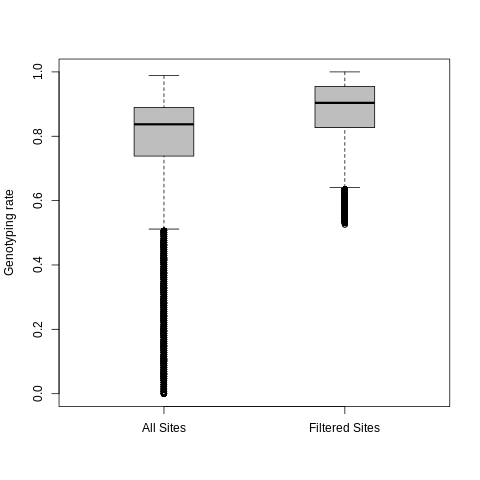

In [114]:
%%R

#gt_rate_all_sites_tbl<-read.table("results/variant_filtration/gt_rate_per_site.tbl", header=TRUE)
#gt_rate_flt_sites_tbl<-read.table("results/variant_filtration/gt_rate_per_site_at_filtered_sites.tbl", header=TRUE)

#head(gt_rate_flt_sites_tbl)

boxplot(1-gt_rate_all_sites_tbl$F_MISS, 
        1-gt_rate_flt_sites_tbl$F_MISS,
        notch=FALSE,
        ylab="Genotyping rate",
        col=c("grey", "grey"),
        names=c("All Sites", "Filtered Sites"),
        boxwex=0.33
       )



#hist(1-gt_rate_flt_sites_tbl$F_MISS)

In [7]:
#read vcf to get all samples and store based on genome or exome
vcf_reader = vcf.Reader(open('results/variant_filtration/smv7_ex_snps.vcf', 'r'))

samples={}
samples['genome'] = [x for x in vcf_reader.samples if re.search("^ER", x)]     
samples['exome'] = [x for x in vcf_reader.samples if not re.search("^ER", x)]     

#create empty df to store info
df = pd.DataFrame(index=[samples['exome'] + samples['genome']])


#fxn to count num seqs in fastq.gz file
def num_seqs(in_fastq_gz):
    n=0
    with gzip.open(in_fastq_gz, "rt") as handle:
        for record in SeqIO.parse(handle, "fastq"):
            n=n+1
    return n

In [15]:
import pysam
samfile = pysam.AlignmentFile("results/mapped_reads/Sm.BR_PdV.0447.1_processed.bam", "rb")


In [16]:
samfile.mapped

18207430

In [ ]:
#get all read count info

num_raws  = []
num_filts = []
num_maps  = []
seq_types = []
#count num of raw and filtered reads
for sample in samples['exome'] + samples['genome']:
    seq_type = ""
    
    if sample in samples['exome']:
        raw_file = "data/exomes/{}_R1.fastq.gz".format(sample)
        seq_type = "exome"
    if sample in samples['genome']:
        raw_file = "data/sra/{}_1.fastq.gz".format(sample)
        seq_type = "genome"
        
    filtered_file = "results/filtered_reads/{}_filtered_R1.fastq.gz".format(sample)
    bam_file = pysam.AlignmentFile("results/mapped_reads/{}_processed.bam".format(sample), "rb")
    
    #raw reads
    num_raw = num_seqs(raw_file)
    
    #filtered reads
    num_filt = num_seqs(filtered_file)


    #count num mapped reads
    num_map = samfile.mapped

    seq_types.append(seq_type)
    num_raws.append(num_raw)
    num_filts.append(num_filt)
    num_maps.append(num_map)
    
    print("{}\t{}\t{}\t{}\t{}".format(sample, seq_type, num_raw, num_filt, num_map))
    
df.insert(0,'seq_type', seq_types)
df.insert(1,'num_raw', num_raws)
df.insert(2,'num_filt', num_filts)
df.insert(3,'mapped_reads', num_maps)

In [ ]:
df

In [ ]:
#now get gt info

for sample in samples['exome'] + samples['genome']:
    
    #count num gtd
    raw_vcf = 'results/genotype/cohort_raw.vcf'
    
    
    #count num in final vcf file

    #count depth of final vcf per site